In [60]:
import numpy as np
#matplotlib inline
import matplotlib.pyplot as plt
#Import LMfit to minimize chi^2.
import lmfit
from lmfit import Minimizer, Parameters, report_fit
#from lmfit import minimize, Parameters
#Allows me to mess with recursion limit. Default probably 1000. Be careful!
import sys 
# generate random integer values
from random import seed
from random import random
from random import randint
#Numpy randoms give all outputs in arrays.
# from numpy.random import seed
# from numpy.random import randint

#Constants
pi = 3.141592654
deg2rad = pi/180.0
GeV2fm = 1./0.0389                  #Convert Q^2 units from GeV^2 to fm^-2.
hbar = 6.582*np.power(10.0,-16.0)   #hbar in [eV*s].
alpha = 0.0072973525664             #Fine structure constant.
C = 299792458.0                     #Speed of light [m/s].
e = 1.60217662E-19                  #Electron charge [C].
e2_nuclear = 1.4399643929e-3        #Electron charge squared in nuclear units [GeV * fm].
MtHe3 = 3.0160293*0.9315            #Mass of He3 in GeV.
muHe3 = -2.1275*(3.0/2.0)           #Magnetic moment of 3He.
Z = 2                               #Atomic number of 3He.
A = 3                               #Number of nucleons.
gamma = 0.8*np.power(2.0/3.0,0.5);  #Gaussian width [fm] from Amroun gamma*sqrt(3/2) = 0.8 fm.

#Flags and Variables that are often modified.
ngaus = 12                          #Number of Guassians in fit.
print_data = 0                      #Prints experimental data.
print_XS_debug = 0                  #Prints individual parts of XS calculation.
force_Fch_1 = 1                     #Forces the sum of the Qich to equal 1.
force_Fm_1 = 1                      #Forces the sum of the Qim to equal 1.
use_rand = 1                        #Use semi-random starting Ri vlues.

if use_rand == 1:
    #Generate semi-random starting Ri values.
    R0 = randint(0, 3)/10
    if R0 == 0:
        R0 = 0.01
        R1 = randint(3, 4)/10
    else:
        R1 = randint(3, 4)/10 + R0 
    R2 = randint(3, 4)/10 + R1
    R3 = randint(3, 4)/10 + R2
    R4 = randint(3, 4)/10 + R3
    R5 = randint(3, 4)/10 + R4
    R6 = randint(3, 4)/10 + R5
    R7 = randint(5, 6)/10 + R6
    R8 = randint(5, 6)/10 + R7
    R9 = randint(5, 6)/10 + R8
    R10 = randint(5, 6)/10 + R9
    R11 = randint(5, 6)/10 + R10
    R = (R0,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11)
    
    
#    R = (0,0,0,0,0,0,0,0,0,0,0,0)
#     R = (randint(1, 10)/10,
#          randint(1, 10)/10+R[1],
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10,
#          randint(1, 10)/10)
    #R[0] = 5
    #R[1] = 7
    print(R)
    #print(sum(R))
#Otherwise use a given set of Ri values.
else:
    R = (0.3,0.7,0.9,1.1,1.5,1.6,2.2,2.7,3.3,4.2,4.3,4.8)

#Read in data file with cross section world data.
E0,theta,sigexp,uncertainty,dataset = np.loadtxt('3He_Data.txt', skiprows=2, unpack=True)
#Print data file.
if print_data == 1:
    print(E0)
    print(theta)
    print(sigexp)
    print(uncertainty)
    print(dataset)

#Define charge form factor function.
def Fch(Q2eff,Qich,R):
    sumFch_ff = 0
    Fch_ff = 0
    for i in range(ngaus):
        sumFch_ff = (Qich[i]/(1.0+2.0*np.power(R[i],2.0)/np.power(gamma,2.0))) * ( np.cos(np.power(Q2eff,0.5)*R[i]) + (2.0*np.power(R[i],2.0)/np.power(gamma,2.0)) * (np.sin(np.power(Q2eff,0.5)*R[i])/(np.power(Q2eff,0.5)*R[i])) )
        Fch_ff = Fch_ff + sumFch_ff
    Fch_ff =  Fch_ff * np.exp(-0.25*Q2eff*np.power(gamma,2.0))
    return Fch_ff

#Define magnetic form factor function.
def Fm(Q2eff,Qim,R):
    sumFm_ff = 0
    Fm_ff = 0
    for i in range(ngaus):
        sumFm_ff = (Qim[i]/(1.0+2.0*np.power(R[i],2.0)/np.power(gamma,2.0))) * ( np.cos(np.power(Q2eff,0.5)*R[i]) + (2.0*np.power(R[i],2.0)/np.power(gamma,2.0)) * (np.sin(np.power(Q2eff,0.5)*R[i])/(np.power(Q2eff,0.5)*R[i])) )
        Fm_ff = Fm_ff + sumFm_ff
    Fm_ff =  Fm_ff * np.exp(-0.25*Q2eff*np.power(gamma,2.0))
    return Fm_ff

#Define cross section function. Takes in E0 and theta along with free parameters Qich and Qim.
def XS(E0,theta,Q0ch,Q1ch,Q2ch,Q3ch,Q4ch,Q5ch,Q6ch,Q7ch,Q8ch,Q9ch,Q10ch,Q11ch,Q0m,Q1m,Q2m,Q3m,Q4m,Q5m,Q6m,Q7m,Q8m,Q9m,Q10m,Q11m):
    
    params = [Q0ch,Q1ch,Q2ch,Q3ch,Q4ch,Q5ch,Q6ch,Q7ch,Q8ch,Q9ch,Q10ch,Q11ch,Q0m,Q1m,Q2m,Q3m,Q4m,Q5m,Q6m,Q7m,Q8m,Q9m,Q10m,Q11m]
    
    #Define variables needed to get XS.
    Ef = E0/(1.0+2.0*E0*np.power(np.sin(theta*deg2rad/2.0),2.0)/MtHe3)     #Scattered electron energy (GeV).
    Q2 = 4.0*E0*Ef*np.power(np.sin(theta*deg2rad/2.0),2.0) * GeV2fm        #Squared four-momentum (fm^-2).
    Q2eff = np.power( np.power(Q2,0.5) * (1.0+(1.5*Z*alpha)/(E0*np.power(GeV2fm,0.5)*1.12*np.power(A,1.0/3.0))) ,2.0)  #Effective Q^2 (fm^-2).
    W = E0 - Ef                                                         #Energy transfer (GeV).
    q2_3 = abs(  np.power(W,2.0)*GeV2fm - Q2eff  )                      #Three-momentum squared (fm^-2).
    eta = 1.0 + Q2eff/(4.0*np.power(MtHe3,2.0)*GeV2fm)                  #Constant eta from Rosenbluth equation in Amroun 1994.
    #Mott XS (fm^-2).
    mottxs = (  (np.power(Z,2.)*(Ef/E0)) * (np.power(alpha,2.0)/(4.0*np.power(E0,2.0)*np.power(np.sin(theta*deg2rad/2.0),4.0)))*np.power(np.cos(theta*deg2rad/2.0),2.0)  ) * 1.0/25.7
    
    #Loop to sum the charge form factor.
    Fch_xs = 0
    for i in range(ngaus):
        sumFch_xs = (params[i]/(1.0+2.0*np.power(R[i],2.0)/np.power(gamma,2.0))) * ( np.cos(np.power(Q2eff,0.5)*R[i]) + (2.0*np.power(R[i],2.0)/np.power(gamma,2.0)) * (np.sin(np.power(Q2eff,0.5)*R[i])/(np.power(Q2eff,0.5)*R[i])) )
        Fch_xs = Fch_xs +sumFch_xs
    Fch_xs =  Fch_xs * np.exp(-0.25*Q2eff*np.power(gamma,2.0))
        
    #Loop to sum the magnetic form factor.
    Fm = 0
    for i in range(ngaus):
        sumFm = (params[i+ngaus]/(1.0+2.0*np.power(R[i],2.0)/np.power(gamma,2.0))) * ( np.cos(np.power(Q2eff,0.5)*R[i]) + (2.0*np.power(R[i],2.0)/np.power(gamma,2.0)) * (np.sin(np.power(Q2eff,0.5)*R[i])/(np.power(Q2eff,0.5)*R[i])) )
        Fm = Fm +sumFm
    Fm =  Fm * np.exp(-0.25*Q2eff*np.power(gamma,2.0))
    
    #Calculate full cross section.
    XS = mottxs * (1./eta) * ( (Q2eff/q2_3)*np.power(Fch_xs,2.) + (np.power(muHe3,2.0)*Q2eff/(2*np.power(MtHe3,2)*GeV2fm))*(0.5*Q2eff/q2_3 + np.power(np.tan(theta*deg2rad/2),2))*np.power(Fm,2.) )
    
    if print_XS_debug == 1:
        print('Ef = ',Ef)
        print('Q^2 = ',Q2)
        print('Q^2 Effective = ',Q2eff)
        print('W = ',W)
        print('Three-momentum Squared = ',q2_3)
        print('eta = ',eta)
        print('Mott XS = ',mottxs)
        print('Fch = ',Fch)
        print('Fm = ',Fm)
        print('XS = ',XS)
    
    return XS

(0.1, 0.5, 0.9, 1.3, 1.7000000000000002, 2.1, 2.4, 3.0, 3.5, 4.1, 4.6, 5.1)


In [61]:
#Import lmfit Model for the least squares minimization.
from lmfit import Model

In [113]:
#pars = Parameters()

#Set up a model using the XS equation with two independednt variables E0 and theta.
model=Model(XS, independent_vars=['E0','theta'])

#pars = model.make_params()

#Create a set of parameters.
pars = Parameters()

#Provide the names, initial values, and bounds of parameters.
pars.add('Q0ch', value=0.0996392, min=0, max=1.0)
pars.add('Q1ch', value=0.214304, min=0, max=1.0)
pars.add('Q2ch', value=0.0199385, min=0, max=1.0)
pars.add('Q3ch', value=0.195676, min=0, max=1.0)
pars.add('Q4ch', value=0.0785533, min=0, max=1.0)
pars.add('Q5ch', value=0.167223, min=0, max=1.0)
pars.add('Q6ch', value=0.126926, min=0, max=1.0)
pars.add('Q7ch', value=0.0549379, min=0, max=1.0)
pars.add('Q8ch', value=0.0401401, min=0, max=1.0)
pars.add('Q9ch', value=0.0100803, min=0, max=1.0)
pars.add('Q10ch', value=0.0007217, min=0, max=1.0)
pars.add('Q11ch', value=4.98962e-12, min=0, max=1.0)
pars.add('Q0m', value=0.159649, min=0, max=1.0)
pars.add('Q1m', value=0.0316168, min=0, max=1.0)
pars.add('Q2m', value=0.277843, min=0, max=1.0)
pars.add('Q3m', value=0.0364955, min=0, max=1.0)
pars.add('Q4m', value=0.0329718, min=0, max=1.0)
pars.add('Q5m', value=0.233469, min=0, max=1.0)
pars.add('Q6m', value=0.117059, min=0, max=1.0)
pars.add('Q7m', value=0.0581085, min=0, max=1.0)
pars.add('Q8m', value=0.0485212, min=0, max=1.0)
pars.add('Q9m', value=1.77602e-12, min=0, max=1.0)
pars.add('Q10m', value=0.0240927, min=0, max=1.0)
pars.add('Q11m', value=8.94934e-12, min=0, max=1.0)
#pars.add('sumch', value=1,vary=0)
#pars.add('sumch', expr='1-Q0ch-Q1ch')
#pars.add('sumch', expr='1-Q0ch-Q1ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch-Q11ch')
#pars.add('Q0ch', expr='1-Q1ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch-Q11ch')

#Add a relation forcing the sum Qich = 1. Has dependence on which variable you force equal to (1-the others). 
if force_Fch_1 == 1:
    pars.add('Q1ch', expr='1-Q0ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch-Q11ch')
    #pars.add('Q1ch', expr='1-Q0ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch-Q11ch') #Defining two pars as the sum equalling 1 leads to a recursion error.
    #pars.add('Q11ch', expr='1-Q0ch-Q1ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch')
    #pars.add('Q11ch', min=0, max=1.0, expr='1-Q0ch-Q1ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch')
    
#Add a relation forcing the sum Qim = 1. Has dependence on which variable you force equal to (1-the others). 
if force_Fm_1 == 1:
    pars.add('Q0m', expr='1-Q1m-Q2m-Q3m-Q4m-Q5m-Q6m-Q7m-Q8m-Q9m-Q10m-Q11m')

#pars = model.make_params()

# model.set_param_hint('Q0ch', value=0.0896392, min=0, max=1.0)
# model.set_param_hint('Q1ch', value=0.214304, min=0, max=1.0)
# model.set_param_hint('Q2ch', value=0.0199385, min=0, max=1.0)
# model.set_param_hint('Q3ch', value=0.195676, min=0, max=1.0)
# model.set_param_hint('Q4ch', value=0.0785533, min=0, max=1.0)
# model.set_param_hint('Q5ch', value=0.167223, min=0, max=1.0)
# model.set_param_hint('Q6ch', value=0.126926, min=0, max=1.0)
# model.set_param_hint('Q7ch', value=0.0549379, min=0, max=1.0)
# model.set_param_hint('Q8ch', value=0.0401401, min=0, max=1.0)
# model.set_param_hint('Q9ch', value=0.0100803, min=0, max=1.0)
# model.set_param_hint('Q10ch', value=0.0007217, min=0, max=1.0)
# model.set_param_hint('Q11ch', value=4.98962e-12, min=0, max=1.0)
# model.set_param_hint('Q0m', value=0.159649, min=0, max=1.0)
# model.set_param_hint('Q1m', value=0.0316168, min=0, max=1.0)
# model.set_param_hint('Q2m', value=0.277843, min=0, max=1.0)
# model.set_param_hint('Q3m', value=0.0364955, min=0, max=1.0)
# model.set_param_hint('Q4m', value=0.0329718, min=0, max=1.0)
# model.set_param_hint('Q5m', value=0.233469, min=0, max=1.0)
# model.set_param_hint('Q6m', value=0.117059, min=0, max=1.0)
# model.set_param_hint('Q7m', value=0.0581085, min=0, max=1.0)
# model.set_param_hint('Q8m', value=0.0485212, min=0, max=1.0)
# model.set_param_hint('Q9m', value=1.77602e-12, min=0, max=1.0)
# model.set_param_hint('Q10m', value=0.0240927, min=0, max=1.0)
# model.set_param_hint('Q11m', value=8.94934e-12, min=0, max=1.0)

#pars = model.make_params()

In [114]:
#sys.setrecursionlimit(20000)  #Ups Python recursion limit, but even at 20000 trying to set Q0ch and Q1ch with all vars sum to one kills the kernel.
#result=model.fit(sigexp,E0=E0,theta=theta,Q0ch=0.0896392,Q1ch=0.214304,Q2ch=0.0199385,Q3ch=0.195676,Q4ch=0.0785533,Q5ch=0.167223,Q6ch=0.126926,Q7ch=0.0549379,Q8ch=0.0401401,Q9ch=0.0100803,Q10ch=0.0007217,Q11ch=4.98962e-12,Q0m=0.159649,Q1m=0.0316168,Q2m=0.277843,Q3m=0.0364955,Q4m=0.0329718,Q5m=0.233469,Q6m=0.117059,Q7m=0.0581085,Q8m=0.0485212,Q9m=1.77602e-12,Q10m=0.0240927,Q11m=8.94934e-12,weights=1/uncertainty)
#result=model.fit(sigexp,E0=E0,theta=theta,pars) #Bad
#result=model.fit(sigexp,E0=E0,theta=theta,Q0ch,Q1ch=0.214304,Q2ch=0.0199385,Q3ch=0.195676,Q4ch=0.0785533,Q5ch=0.167223,Q6ch=0.126926,Q7ch=0.0549379,Q8ch=0.0401401,Q9ch=0.0100803,Q10ch=0.0007217,Q11ch=4.98962e-12,Q0m=0.159649,Q1m=0.0316168,Q2m=0.277843,Q3m=0.0364955,Q4m=0.0329718,Q5m=0.233469,Q6m=0.117059,Q7m=0.0581085,Q8m=0.0485212,Q9m=1.77602e-12,Q10m=0.0240927,Q11m=8.94934e-12,weights=1/uncertainty)

#Perform a least squares minimization fit on the XS (sigexp) data using E0 and theta as independent variables.
#The weights are given as 1/uncertainty.
result=model.fit(sigexp,pars,E0=E0,theta=theta,weights=1/uncertainty)
#Print model independent variables.
print(model.independent_vars)
#pars.pretty_print()

#Implement Ri optimization.

['E0', 'theta']


In [115]:
#Print the results of the model fit.
print(result.fit_report())

[[Model]]
    Model(XS)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29703
    # data points      = 259
    # variables        = 22
    chi-square         = 560.176867
    reduced chi-square = 2.36361547
    Akaike info crit   = 243.798947
    Bayesian info crit = 322.049164
##  Warning: uncertainties could not be estimated:
    Q6ch:   at boundary
    Q9ch:   at boundary
    Q10ch:  at boundary
    Q11ch:  at initial value
    Q11ch:  at boundary
[[Variables]]
    Q0ch:   0.07694067 (init = 0.0996392)
    Q1ch:   0.11221131 == '1-Q0ch-Q2ch-Q3ch-Q4ch-Q5ch-Q6ch-Q7ch-Q8ch-Q9ch-Q10ch-Q11ch'
    Q2ch:   0.18525100 (init = 0.0199385)
    Q3ch:   0.27019413 (init = 0.195676)
    Q4ch:   0.14930361 (init = 0.0785533)
    Q5ch:   0.10293006 (init = 0.167223)
    Q6ch:   1.1102e-16 (init = 0.126926)
    Q7ch:   0.07996055 (init = 0.0549379)
    Q8ch:   0.02320869 (init = 0.0401401)
    Q9ch:   5.5511e-17 (init = 0.0100803)
    Q10ch:  1.1102e-16 (init = 0.0007217

In [116]:
#Print out the Qi fit parameters.
Qich = [result.best_values['Q0ch'],result.best_values['Q1ch'],result.best_values['Q2ch'],result.best_values['Q3ch'],result.best_values['Q4ch'],result.best_values['Q5ch'],result.best_values['Q6ch'],result.best_values['Q7ch'],result.best_values['Q8ch'],result.best_values['Q9ch'],result.best_values['Q10ch'],result.best_values['Q11ch']]
print(Qich)
Qim = [result.best_values['Q0m'],result.best_values['Q1m'],result.best_values['Q2m'],result.best_values['Q3m'],result.best_values['Q4m'],result.best_values['Q5m'],result.best_values['Q6m'],result.best_values['Q7m'],result.best_values['Q8m'],result.best_values['Q9m'],result.best_values['Q10m'],result.best_values['Q11m']]
print(Qim)
Qich_init = [result.init_values['Q0ch'],result.init_values['Q1ch'],result.init_values['Q2ch'],result.init_values['Q3ch'],result.init_values['Q4ch'],result.init_values['Q5ch'],result.init_values['Q6ch'],result.init_values['Q7ch'],result.init_values['Q8ch'],result.init_values['Q9ch'],result.init_values['Q10ch'],result.init_values['Q11ch']]
print(Qich_init)
Qim_init = [result.init_values['Q0m'],result.init_values['Q1m'],result.init_values['Q2m'],result.init_values['Q3m'],result.init_values['Q4m'],result.init_values['Q5m'],result.init_values['Q6m'],result.init_values['Q7m'],result.init_values['Q8m'],result.init_values['Q9m'],result.init_values['Q10m'],result.init_values['Q11m']]
print(Qim_init)

#Print sums of the Qi fit parameters.
print('Sum of Electric Charges = ',sum(Qich))
print('Sum of Magnetic Charges = ',sum(Qim))

[0.0769406670989638, 0.11221131303805565, 0.18525099524054855, 0.2701941269820479, 0.14930361087141264, 0.10293005559843604, 1.1102230246251565e-16, 0.07996054571659633, 0.02320868545393867, 5.551115123125783e-17, 1.1102230246251565e-16, 5.551115123125783e-17]
[0.06090985307234925, 0.1546496894043063, 0.22874143208176811, 0.15619185081437248, 0.16863628457368507, 0.09639375200309325, 0.03863949586770726, 0.07163874068096587, 0.01353096542661697, 0.0004825024612484796, 0.004776403101250881, 0.005409030512636026]
[0.0996392, 0.2061639999950104, 0.0199385, 0.195676, 0.0785533, 0.167223, 0.126926, 0.0549379, 0.0401401, 0.0100803, 0.0007217, 4.98962e-12]
[0.13982249998927462, 0.0316168, 0.277843, 0.0364955, 0.0329718, 0.233469, 0.117059, 0.0581085, 0.0485212, 1.77602e-12, 0.0240927, 8.94934e-12]
Sum of Electric Charges =  1.0
Sum of Magnetic Charges =  1.0


/home/skbarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
/home/skbarcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in true_divide


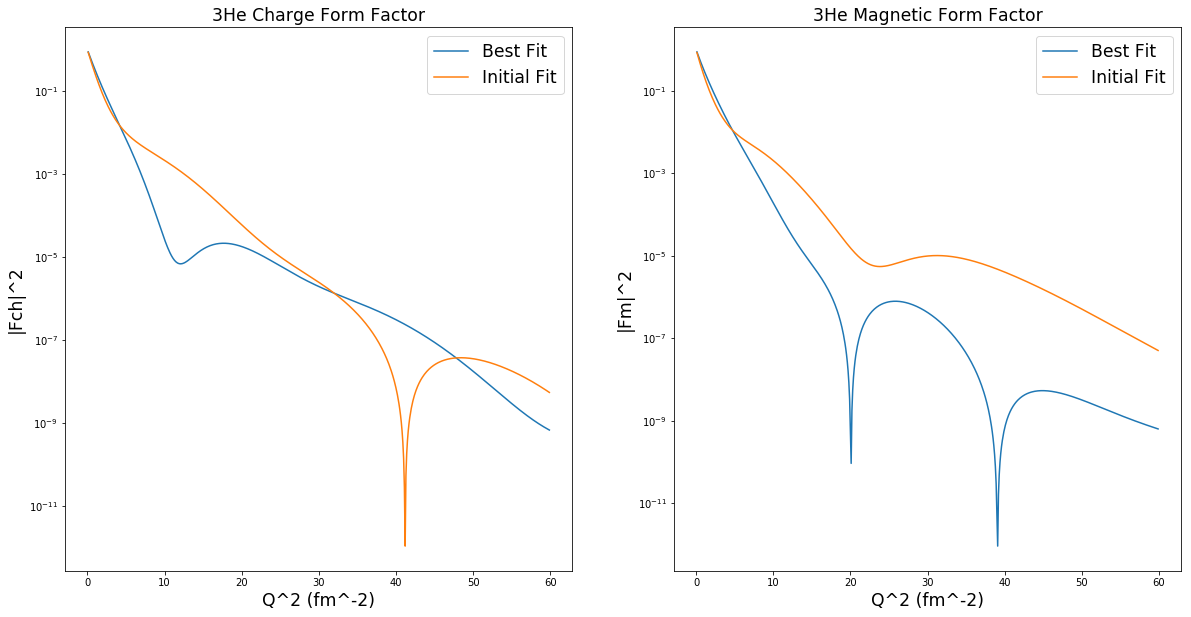

In [117]:
#Create a range to plot from 0-60 fm^-2 in 0.1 increments.
r = np.arange(0, 60, 0.1)
#fig = plt.figure()
#plt.figure(1)

#Create the plot size.
plt.figure(figsize=(20,10))
#Add a first plot.
plt.subplot(121)
#Plot Fch with best fit values.
plt.plot(r, Fch(r,Qich,R)*Fch(r,Qich,R),label='Best Fit')
#Plot Fch with initial fit values.
plt.plot(r, Fch(r,Qich_init,R)*Fch(r,Qich_init,R),label='Initial Fit')
plt.yscale('log')
plt.title('3He Charge Form Factor',fontsize = 'xx-large')
plt.ylabel('|Fch|^2',fontsize = 'xx-large')
plt.xlabel('Q^2 (fm^-2)',fontsize = 'xx-large')
#plt.axis([0, 60, 0, 1])
plt.legend(fontsize = 'xx-large')

#Add a second plot.
plt.subplot(122)
#Plot Fm with best fit values.
plt.plot(r, Fm(r,Qim,R)*Fm(r,Qim,R),label='Best Fit')
#Plot Fm with initial fit values.
plt.plot(r, Fm(r,Qim_init,R)*Fm(r,Qim_init,R),label='Initial Fit')
plt.yscale('log')
plt.title('3He Magnetic Form Factor',fontsize = 'xx-large')
plt.ylabel('|Fm|^2',fontsize = 'xx-large')
plt.xlabel('Q^2 (fm^-2)',fontsize = 'xx-large')
plt.legend(fontsize = 'xx-large')

#Display the plots.
plt.show()

In [10]:
result.plot_residuals()

Fit can only be plotted if the model function has one independent variable.


False

In [11]:
print(result.ci_report())

MinimizerException: Cannot determine Confidence Intervals without sensible uncertainty estimates